# Steganography Detection Model Training



In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import gc
import warnings
warnings.filterwarnings('ignore')

try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    print(f"TensorFlow: {tf.__version__}, GPU Available: {len(gpus) > 0}")
except:
    print("GPU setup warning")

np.random.seed(42)
tf.random.set_seed(42)

TensorFlow: 2.17.0, GPU Available: False


In [2]:
CONFIG = {
    'IMAGE_SIZE': (256, 256),  
    'BATCH_SIZE': 32, 
    'EPOCHS': 20,
    'LEARNING_RATE': 0.0001,
    'VALIDATION_SPLIT': 0.2,
    'TEST_SPLIT': 0.1,
    'NUM_CLASSES': 2,  # 0: Clean, 1: Steganographic
    'DROPOUT_RATE': 0.5,
    'EARLY_STOPPING_PATIENCE': 10,
    'REDUCE_LR_PATIENCE': 5,
}

DATA_DIR = Path(r"data")
CLEAN_IMAGES_DIR = DATA_DIR / "linnaeus5"
ENCODED_IMAGES_DIR = DATA_DIR / "encoded_1x"
MODEL_SAVE_PATH = "steganography_detector_model.keras" 

## Data processing functions

In [3]:
def load_image(image_path):         #Load and preprocess image
    try:
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, CONFIG['IMAGE_SIZE'])
        return image.astype(np.float32) / 255.0
    except:
        return np.zeros((*CONFIG['IMAGE_SIZE'], 3), dtype=np.float32)

    
def augment_image(image):           #Simple data augmentation
    if np.random.random() > 0.5:
        image = np.fliplr(image)
    if np.random.random() > 0.5:
        image = np.clip(image * np.random.uniform(0.8, 1.2), 0, 1)
    return image

## Dataset Preparation

In [4]:
def prepare_dataset():
    """Collect image paths and create train/val/test splits"""
    image_paths, labels = [], []
    
    #  clean images (label 0)
    if CLEAN_IMAGES_DIR.exists():
        clean_files = list(CLEAN_IMAGES_DIR.rglob("*.png")) + list(CLEAN_IMAGES_DIR.rglob("*.jpg"))
        image_paths.extend([str(p) for p in clean_files])
        labels.extend([0] * len(clean_files))
        print(f"Clean images: {len(clean_files)}")
    
    #  encoded images (label 1)
    if ENCODED_IMAGES_DIR.exists():
        encoded_files = list(ENCODED_IMAGES_DIR.rglob("*.png")) + list(ENCODED_IMAGES_DIR.rglob("*.jpg"))
        image_paths.extend([str(p) for p in encoded_files])
        labels.extend([1] * len(encoded_files))
        print(f"Encoded images: {len(encoded_files)}")
    
    if not image_paths:
        raise ValueError("No images found!")
    
    print(f"Total: {len(image_paths)} images")
    
    image_paths, labels = np.array(image_paths), np.array(labels)
    X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=CONFIG['TEST_SPLIT'], stratify=labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=CONFIG['VALIDATION_SPLIT']/(1-CONFIG['TEST_SPLIT']), stratify=y_temp, random_state=42)
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()

Clean images: 8000
Encoded images: 8000
Total: 16000 images
Train: 11200, Val: 3200, Test: 1600


## Model Architecture

In [5]:
def create_complex_steganography_model(input_shape=(256, 256, 3), num_classes=2):

    def conv_block(x, filters, kernel_size=3, strides=1, activation='relu', use_bn=True):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        if use_bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x
    
    def residual_block(x, filters, kernel_size=3):
        """Residual block for better gradient flow"""
        shortcut = x
        
        # First conv layer
        x = conv_block(x, filters, kernel_size)
        x = layers.Dropout(0.1)(x)
        
        # Second conv layer (no activation)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x
    
    def attention_block(x, filters):
        # Global average pooling
        gap = layers.GlobalAveragePooling2D()(x)
        gap = layers.Reshape((1, 1, filters))(gap)
        
        # Global max pooling
        gmp = layers.GlobalMaxPooling2D()(x)
        gmp = layers.Reshape((1, 1, filters))(gmp)
        
        # Concatenate and create attention weights
        concat = layers.Concatenate()([gap, gmp])
        attention = layers.Conv2D(filters, 1, activation='sigmoid')(concat)
        
        return layers.Multiply()([x, attention])
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    x = conv_block(inputs, 32, 7, strides=2)  # 128x128
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)  # 64x64
    
    # Low-level features
    x = conv_block(x, 64, 3)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D(2)(x)  
    
    # Mid-level features
    x = conv_block(x, 128, 3)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = attention_block(x, 128)
    x = layers.MaxPooling2D(2)(x) 
    
    #High-level features
    x = conv_block(x, 256, 3)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = attention_block(x, 256)
    x = layers.MaxPooling2D(2)(x) 
    

    x = conv_block(x, 512, 3)
    x = residual_block(x, 512)
    x = residual_block(x, 512)
    x = attention_block(x, 512)
    x = layers.MaxPooling2D(2)(x) 
    
    # Global features
    branch1 = layers.GlobalAveragePooling2D()(x)
    branch1 = layers.Dense(512, activation='relu')(branch1)
    branch1 = layers.Dropout(CONFIG['DROPOUT_RATE'])(branch1)
    
    # Local features
    branch2 = layers.GlobalMaxPooling2D()(x)
    branch2 = layers.Dense(512, activation='relu')(branch2)
    branch2 = layers.Dropout(CONFIG['DROPOUT_RATE'])(branch2)
    
    # Spatial features
    branch3 = layers.Conv2D(512, 1, activation='relu')(x)
    branch3 = layers.GlobalAveragePooling2D()(branch3)
    branch3 = layers.Dense(512, activation='relu')(branch3)
    branch3 = layers.Dropout(CONFIG['DROPOUT_RATE'])(branch3)
    
    combined = layers.Concatenate()([branch1, branch2, branch3])
    combined = layers.Dense(1024, activation='relu')(combined)
    combined = layers.Dropout(CONFIG['DROPOUT_RATE'])(combined)
    
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.Dropout(CONFIG['DROPOUT_RATE'])(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid', name='binary_output')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax', name='multiclass_output')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='SteganographyDetector')
    return model

model = create_complex_steganography_model(
    input_shape=(*CONFIG['IMAGE_SIZE'], 3), 
    num_classes=CONFIG['NUM_CLASSES']
)

model.summary()

total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

Model: "SteganographyDetector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_3[0][

 Total params: 19,281,473 (73.55 MB)

 Trainable params: 19,270,785 (73.51 MB)

 Non-trainable params: 10,688 (41.75 KB)


Total trainable parameters: 19,281,473


In [6]:
def data_generator(image_paths, labels, batch_size, augment=False):
    while True:
        indices = np.random.permutation(len(image_paths))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_labels = []
            
            for idx in batch_indices:
                image = load_image(image_paths[idx])
                if augment:
                    image = augment_image(image)
                batch_images.append(image)
                batch_labels.append(labels[idx])
            
            yield np.array(batch_images), np.array(batch_labels)

model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

train_generator = data_generator(X_train, y_train, CONFIG['BATCH_SIZE'], augment=True)
val_generator = data_generator(X_val, y_val, CONFIG['BATCH_SIZE'], augment=False)

train_steps = max(1, len(X_train) // CONFIG['BATCH_SIZE'])
val_steps = max(1, len(X_val) // CONFIG['BATCH_SIZE'])

print(f"Training samples: {len(X_train)}, Steps per epoch: {train_steps}")
print(f"Validation samples: {len(X_val)}, Validation steps: {val_steps}")

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=CONFIG['EARLY_STOPPING_PATIENCE'], restore_best_weights=True),
    callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=CONFIG['REDUCE_LR_PATIENCE'], verbose=1)
]

print('--'*50)
print("Training setup complete")
print('--'*50)


Training samples: 11200, Steps per epoch: 350
Validation samples: 3200, Validation steps: 100
----------------------------------------------------------------------------------------------------
Training setup complete
----------------------------------------------------------------------------------------------------


## Model Training

In [7]:
# Train model
print("model training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=CONFIG['EPOCHS'],
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks_list,
    verbose=1
)

print("Training completed!")
gc.collect()

model training...
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4982 - loss: 0.8895 - precision: 0.5050 - recall: 0.5102
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to steganography_detector_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 1456s 4s/step - accuracy: 0.4982 - loss: 0.8893 - precision: 0.5050 - recall: 0.5102 - val_accuracy: 0.5000 - val_loss: 0.6941 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5090 - loss: 0.7401 - precision: 0.5116 - recall: 0.4735
Epoch 2: val_accuracy improved from 0.50000 to 0.51187, saving model to steganography_detector_model.keras
350/350 ━━━━━━━━━━━━━━━━━━━━ 1170s 3s/step - accuracy: 0.5090 - loss: 0.7400 - precision: 0.5116 - recall: 0.4735 - val_accuracy: 0.5119 - val_loss: 0.6925 - val_precision: 0.5385 - val_recall: 0.1663 - learning_rate: 1.0000e-04
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy

787

## Model Evaluation

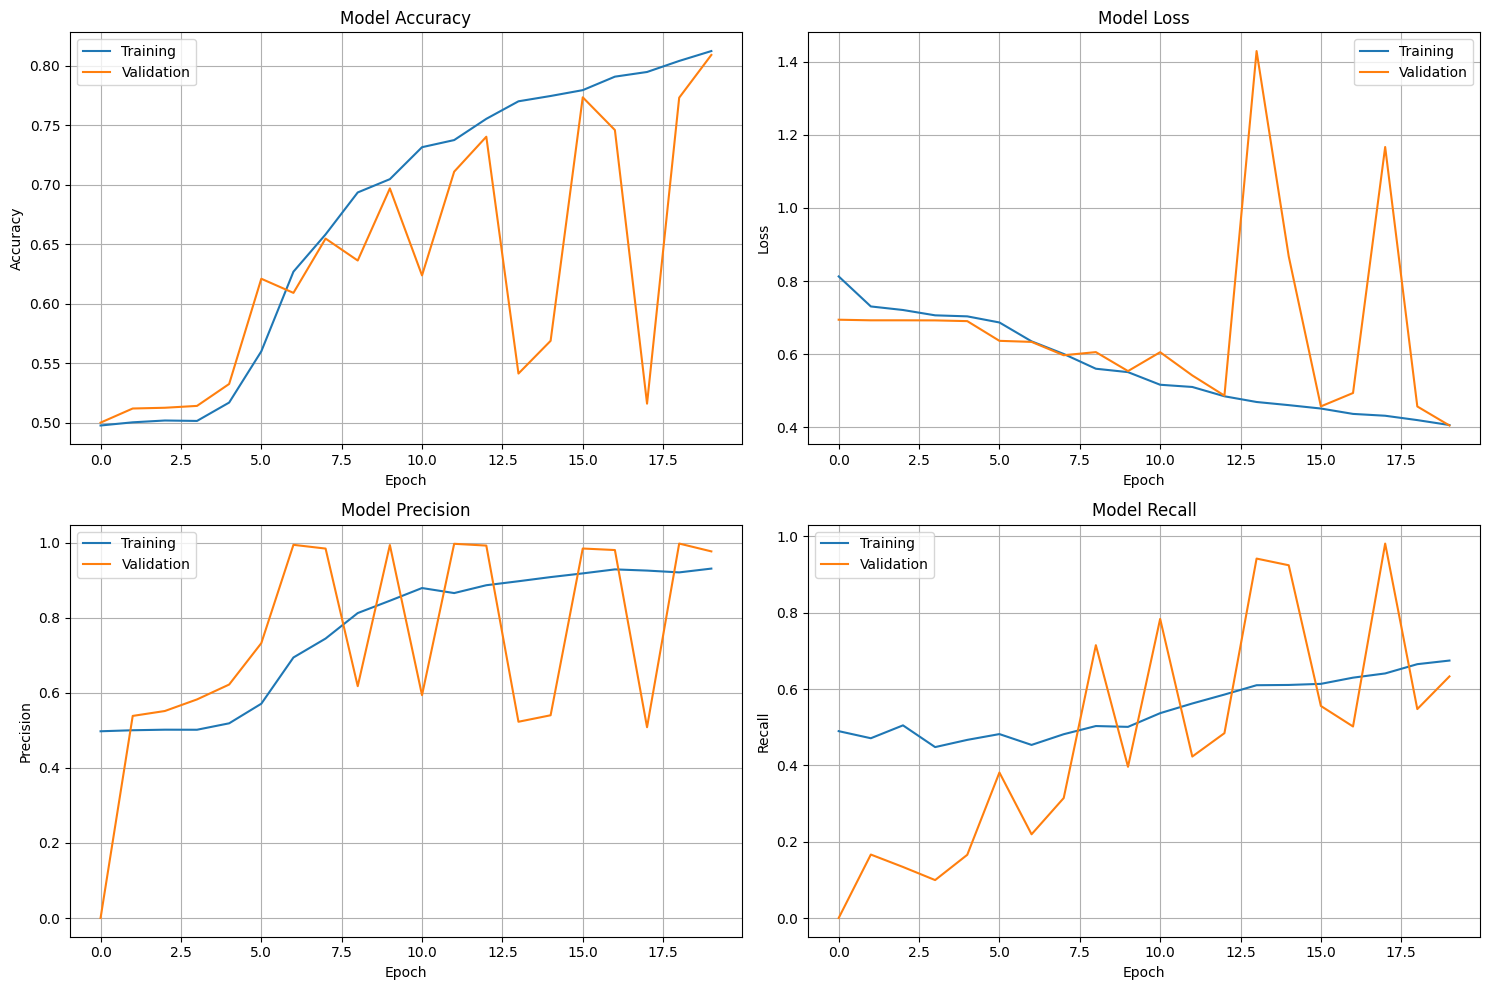

In [8]:
def plot_training_history(history):
    if history is None:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    titles = ['Accuracy', 'Loss', 'Precision', 'Recall']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        ax.plot(history.history[metric], label='Training')
        ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(f'Model {title}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('images/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_training_history(history)

Test Accuracy: 0.8075
AUC Score: 0.8596

                precision    recall  f1-score   support

         Clean       0.72      0.99      0.84       800
Steganographic       0.99      0.62      0.76       800

      accuracy                           0.81      1600
     macro avg       0.86      0.81      0.80      1600
  weighted avg       0.86      0.81      0.80      1600



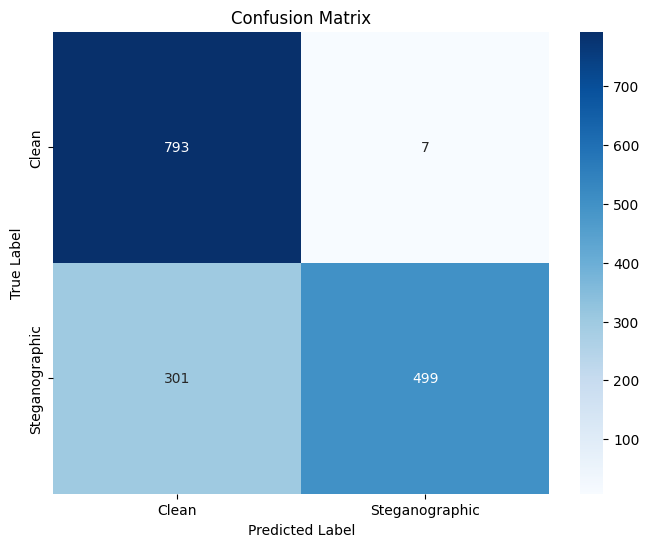

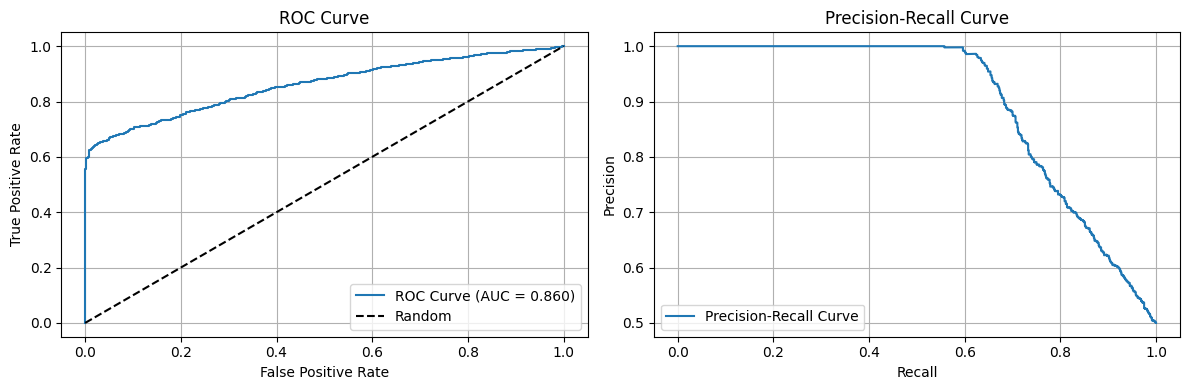

In [9]:

test_predictions = []
test_labels = []

for i in range(0, len(X_test), CONFIG['BATCH_SIZE']):
    end_idx = min(i + CONFIG['BATCH_SIZE'], len(X_test))
    batch_images = [load_image(X_test[j]) for j in range(i, end_idx)]
    batch_labels = [y_test[j] for j in range(i, end_idx)]
    
    batch_predictions = model.predict(np.array(batch_images), verbose=0)
    test_predictions.extend(batch_predictions)
    test_labels.extend(batch_labels)

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
predicted_classes = (test_predictions > 0.5).astype(int).flatten()

accuracy = np.mean(predicted_classes == test_labels)
auc_score = roc_auc_score(test_labels, test_predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")

print("\n" + classification_report(test_labels, predicted_classes, target_names=['Clean', 'Steganographic']))

cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clean', 'Steganographic'], 
            yticklabels=['Clean', 'Steganographic'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC and PR curves
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
precision, recall, _ = precision_recall_curve(test_labels, test_predictions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True)

ax2.plot(recall, precision, label='Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('images/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## Steganalysis

Sample prediction:
True: Steganographic
Predicted: Steganographic
Confidence: 0.9699


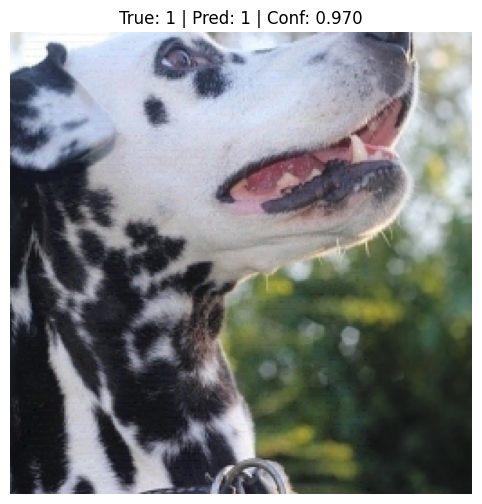

Training summary saved!
Model saved as: steganography_detector_model.keras


In [10]:
def predict_image(model, image_path):
    """Predict if image contains steganographic content"""
    image = load_image(image_path)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image, verbose=0)[0][0]
    predicted_class = 1 if prediction > 0.5 else 0
    confidence = prediction if predicted_class == 1 else 1 - prediction
    return predicted_class, confidence

if len(X_test) > 0:
    sample_path = X_test[0]
    true_label = y_test[0]
    pred_class, confidence = predict_image(model, sample_path)
    
    print(f"Sample prediction:")
    print(f"True: {'Steganographic' if true_label == 1 else 'Clean'}")
    print(f"Predicted: {'Steganographic' if pred_class == 1 else 'Clean'}")
    print(f"Confidence: {confidence:.4f}")
    
    img = load_image(sample_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_class} | Conf: {confidence:.3f}")
    plt.axis('off')
    plt.show()

summary = {
    'model_architecture': 'Complex CNN with Residual Blocks and Attention',
    'total_parameters': model.count_params(),
    'image_size': CONFIG['IMAGE_SIZE'],
    'batch_size': CONFIG['BATCH_SIZE'],
    'epochs_trained': len(history.history['loss']),
    'learning_rate': CONFIG['LEARNING_RATE'],
    'final_accuracy': accuracy,
    'auc_score': auc_score
}

with open('training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("Training summary saved!")
print(f"Model saved as: {MODEL_SAVE_PATH}")

In [11]:
try:
    del train_generator, val_generator
    del test_predictions, test_labels, predicted_classes
    del X_train, X_val, X_test, y_train, y_val, y_test
except:
    pass

gc.collect()


17984

In [12]:

print("------- Training completed--------")
print(f" Model saved: {MODEL_SAVE_PATH}")
print(f" Final accuracy: {accuracy:.4f}")
print(f" AUC score: {auc_score:.4f}")

------- Training completed--------
 Model saved: steganography_detector_model.keras
 Final accuracy: 0.8075
 AUC score: 0.8596
